In [3]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pickle
from collections import OrderedDict
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import seaborn as sns
import pandas as pd

In [4]:
#Set seed
seed=41

In [5]:
classif_level = 1

In [6]:
feature_names = pickle.load(open('Dataset/feature_names.pkl', 'rb'))
X_train = pickle.load(open(f'Dataset/X_train.pkl', 'rb'))
X_test = pickle.load(open(f'Dataset/X_test.pkl', 'rb'))
y_train = pickle.load(open(f'Dataset/y_train.pkl', 'rb'))
y_test = pickle.load(open(f'Dataset/y_test.pkl', 'rb'))
sc_u = pickle.load(open(f'Dataset/SC_wunique_child.pkl', 'rb'))
s_u = pickle.load(open(f'Dataset/C_wunique_child.pkl', 'rb'))
feat_dic = pickle.load(open('Results/selected_features.pkl', 'rb'))

In [ ]:
results = {}
for classif_level, classif_name in {0:'Kingdom', 1:'Superclass', 2:'Class', 3:'Subclass'}.items():
    print(classif_name)
    for class_ in np.unique(y_train[:, classif_level-1]):
        if classif_level == 0:
            class_ = None
        if class_ in sc_u or class_ in s_u:
            continue
        print(class_)
        
        ensemble_clfs = [
    ("Default", RandomForestClassifier(warm_start=True,
                                       oob_score=True,
                                       max_features="sqrt",
                                       class_weight=None,
                                       random_state=seed)
    ),
    ("class_weight='balanced'", RandomForestClassifier(warm_start=True,
                                                       max_features="sqrt",
                                                       class_weight="balanced",
                                                       oob_score=True,
                                                       random_state=seed)
    ),
    ("max_features=None", RandomForestClassifier(warm_start=True,
                                                 max_features=None,
                                                 class_weight=None,
                                                 oob_score=True,
                                                 random_state=seed)
    ),
    ("max_features=None & class_weight='balanced'", RandomForestClassifier(warm_start=True,
                                                                           max_features=None,
                                                                           class_weight="balanced",
                                                                           oob_score=True,
                                                                           random_state=seed)
    ),
    ("Default w/ feature selection", RandomForestClassifier(warm_start=True,
                                                            max_features="sqrt",
                                                            class_weight=None,
                                                            oob_score=True,
                                                            random_state=seed)
    )]
        
        if classif_level == 0:
            X_train_ = X_train
            y_train_ = y_train[:,0]
            key = f'Chemical entities ({classif_name})'
            sel_f = feat_dic[classif_name]['Chemical entities']['selected features']
            
        else:
            X_train_ = X_train[y_train[:,classif_level-1] == class_, :]
            y_train_ = y_train[y_train[:,classif_level-1] == class_][:,classif_level]
            key = f'{class_} ({classif_name})'
            sel_f = feat_dic[classif_name][class_]['selected features']
        
        f_index = [feature_names.index(feature) for feature in sel_f]

        # Range of `n_estimators` values to explore.
        min_estimators = 15
        max_estimators = 150
        if classif_level >= 2:
            max_estimators = 250
        results[key] = {}
        for label, clf in ensemble_clfs:
            print(label)
            results[key][label] = []
            for i in range(min_estimators, max_estimators + 1, 5):
                print(i)
                clf.set_params(n_estimators=i)
                if label == 'Default w/ feature selection':
                    clf.fit(X_train_[:, f_index], y_train_)
                else:
                    clf.fit(X_train_, y_train_)

                # Record the OOB error for each `n_estimators=i` setting.
                oob_error = 1 - clf.oob_score_
                results[key][label].append((i, oob_error))
        if classif_level == 0:
            break

In [ ]:
pickle.dump(results, open('Results/oob.pkl', 'wb'))

In [7]:
results = pickle.load(open('Results/oob.pkl', 'rb'))

In [8]:
df_dict = {'Classifier':[], 'Label':[], 'Number of estimators':[], 'OOB Error':[]}

In [9]:
for key, value in results.items():
    for key2, value2 in value.items():
        for point in value2:
            x = point[0]
            y = point[1] 
            df_dict['Classifier'].append(key)
            df_dict['Label'].append(key2)
            df_dict['Number of estimators'].append(x)
            df_dict['OOB Error'].append(y)

In [10]:
df = pd.DataFrame(df_dict)
df

Classifier                         Label  \
0      Chemical entities (Kingdom)                       Default   
1      Chemical entities (Kingdom)                       Default   
2      Chemical entities (Kingdom)                       Default   
3      Chemical entities (Kingdom)                       Default   
4      Chemical entities (Kingdom)                       Default   
...                            ...                           ...   
33055     Vinyl halides (Subclass)  Default w/ feature selection   
33056     Vinyl halides (Subclass)  Default w/ feature selection   
33057     Vinyl halides (Subclass)  Default w/ feature selection   
33058     Vinyl halides (Subclass)  Default w/ feature selection   
33059     Vinyl halides (Subclass)  Default w/ feature selection   

       Number of estimators  OOB Error  
0                        15   0.001168  
1                        20   0.000355  
2                        25   0.000247  
3                        30   0.000247  
4                        35   0.000232  
...                     ...        ...  
33055                   230   0.031250  
33056                   235   0.031250  
33057                   240   0.031250  
33058                   245   0.031250  
33059                   250   0.031250  

[33060 rows x 4 columns]

In [ ]:
pickle.dump(df, open('Results/oob_df.pkl', 'wb'))

In [11]:
df = pickle.load(open('Results/oob_df.pkl', 'rb'))

In [12]:
df_K_SP = df[((df['Classifier']=='Chemical entities (Kingdom)') | (df['Classifier']=='Inorganic compounds (Superclass)') | (df['Classifier']=='Organic compounds (Superclass)'))]

In [ ]:
sns.set_theme(style='whitegrid', font_scale=1.1)
g = sns.relplot(data=df_K_SP, x='Number of estimators', y='OOB Error', hue='Label', col='Classifier', kind='line', 
                facet_kws=dict(sharey=False), col_wrap=3, height=5)

#Set automatic y limits
for j, col in enumerate(g.axes):
    g.axes[j].set(ylim=None)
g.set(xlim=(15, 150))
sns.move_legend(g, "lower center", bbox_to_anchor=(0.41, -0.1), title=None, ncol=5, fontsize=11)
plt.savefig('Plots/OOB_Score_Kingdom&Superclass', bbox_inches='tight', transparent=True, dpi=500)
plt.show()

In [ ]:
df_C = df[df['Classifier'].str.endswith('(Class)')]

In [ ]:
sns.set_theme(style='whitegrid', font_scale=1.1)

g = sns.relplot(data=df_C, x='Number of estimators', y='OOB Error', hue='Label', col='Classifier', kind='line', 
                facet_kws=dict(sharey=False), col_wrap=4, aspect=1.15)
#Set automatic y limits
for j, col in enumerate(g.axes):
    g.axes[j].set(ylim=None)
g.set(xlim=(15, 250))
sns.move_legend(g, "lower center", bbox_to_anchor=(0.425, -0.02), title=None, ncol=5, fontsize=17)

plt.savefig('Plots/OOB_Score_Class', bbox_inches='tight', transparent=True, dpi=500)
plt.show()

In [13]:
df_subC = df[df['Classifier'].str.endswith('(Subclass)')]

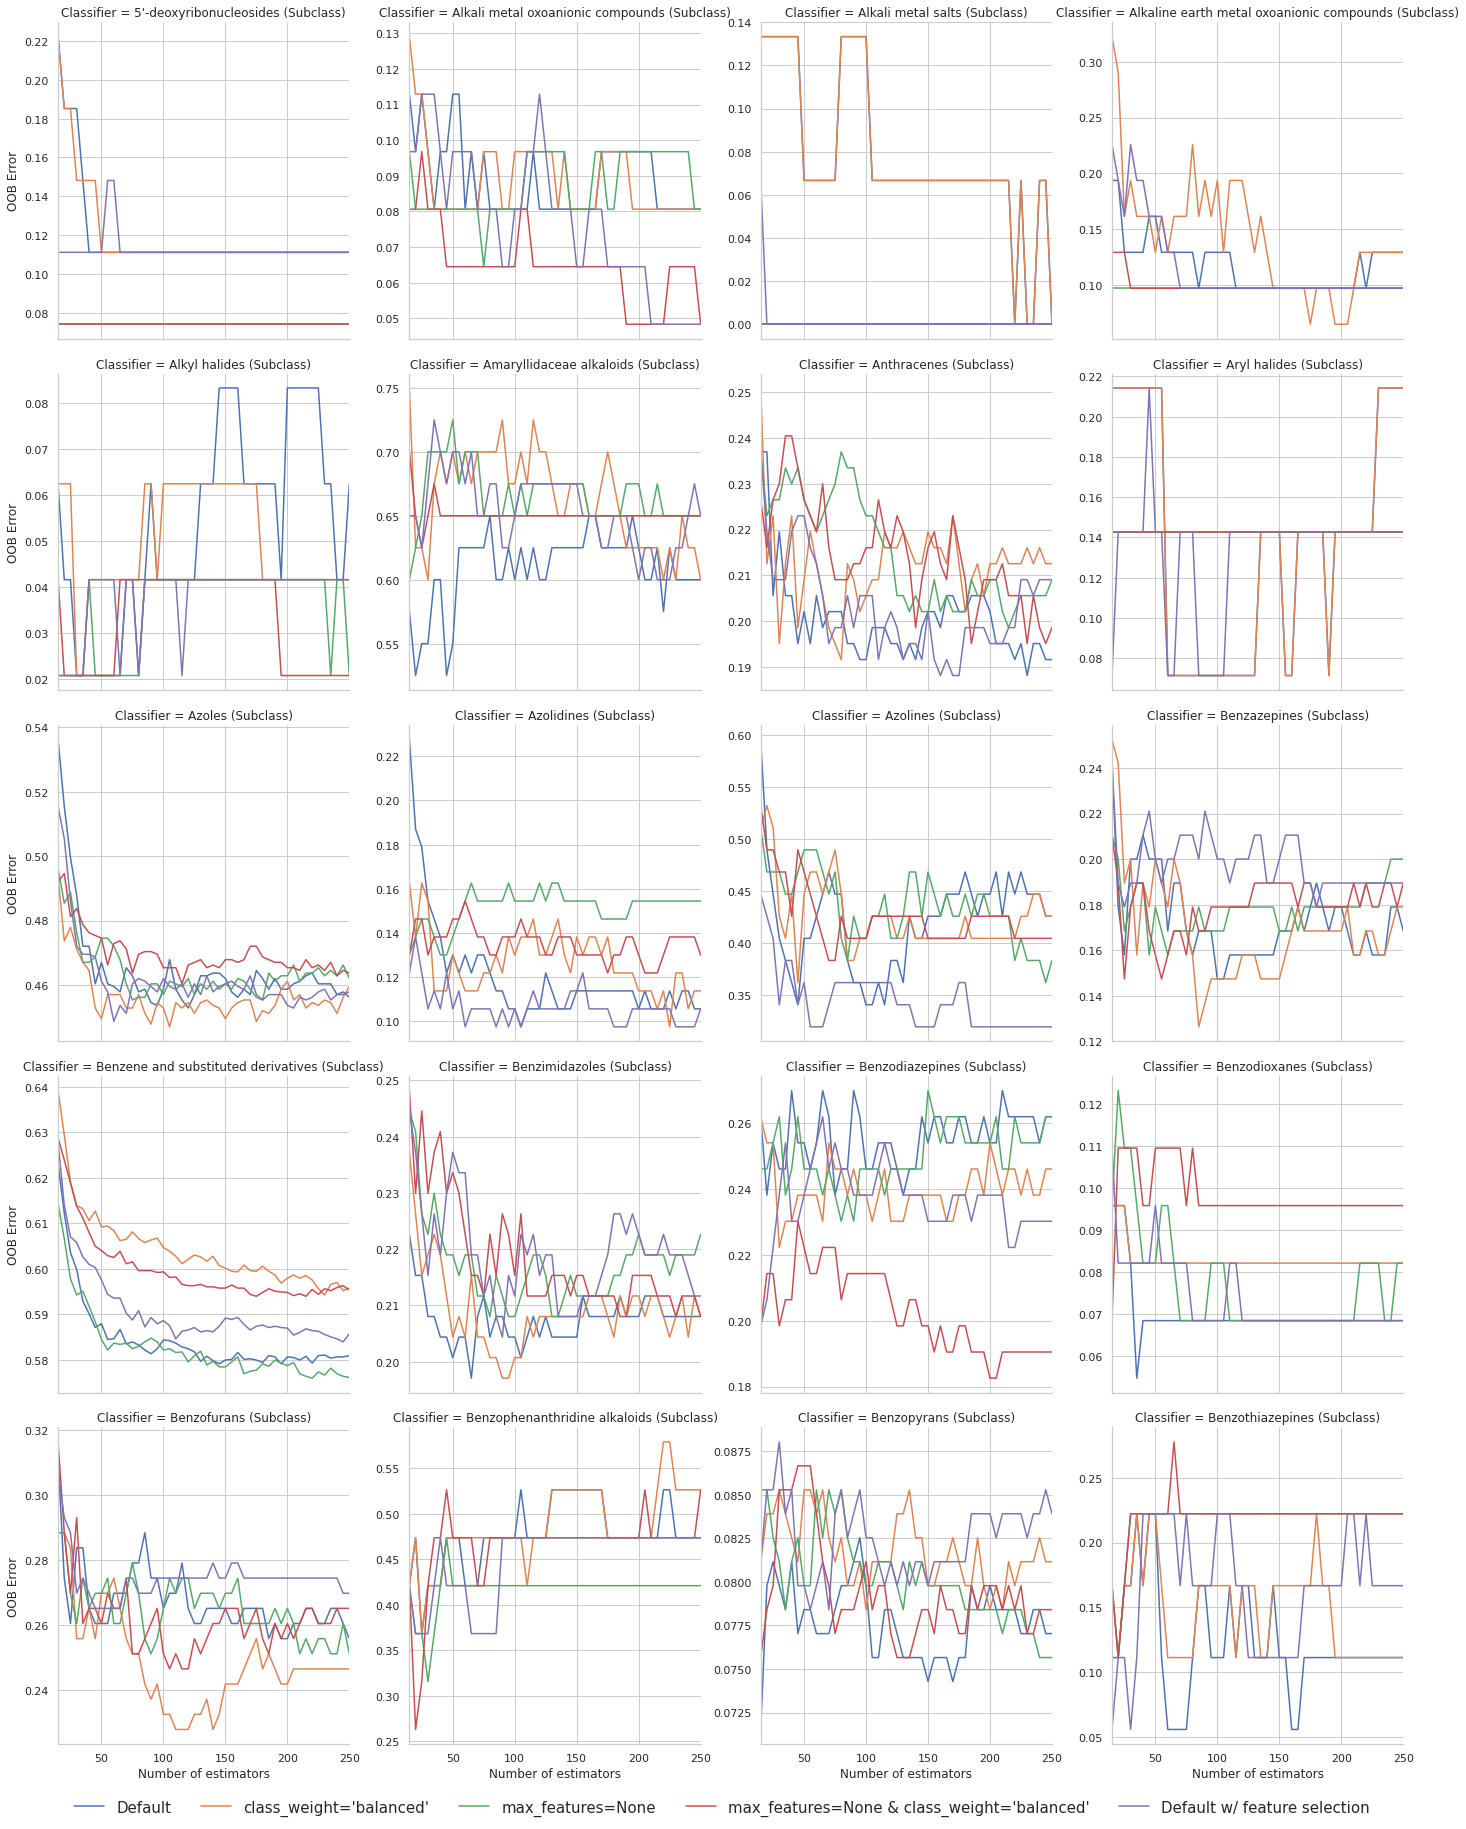

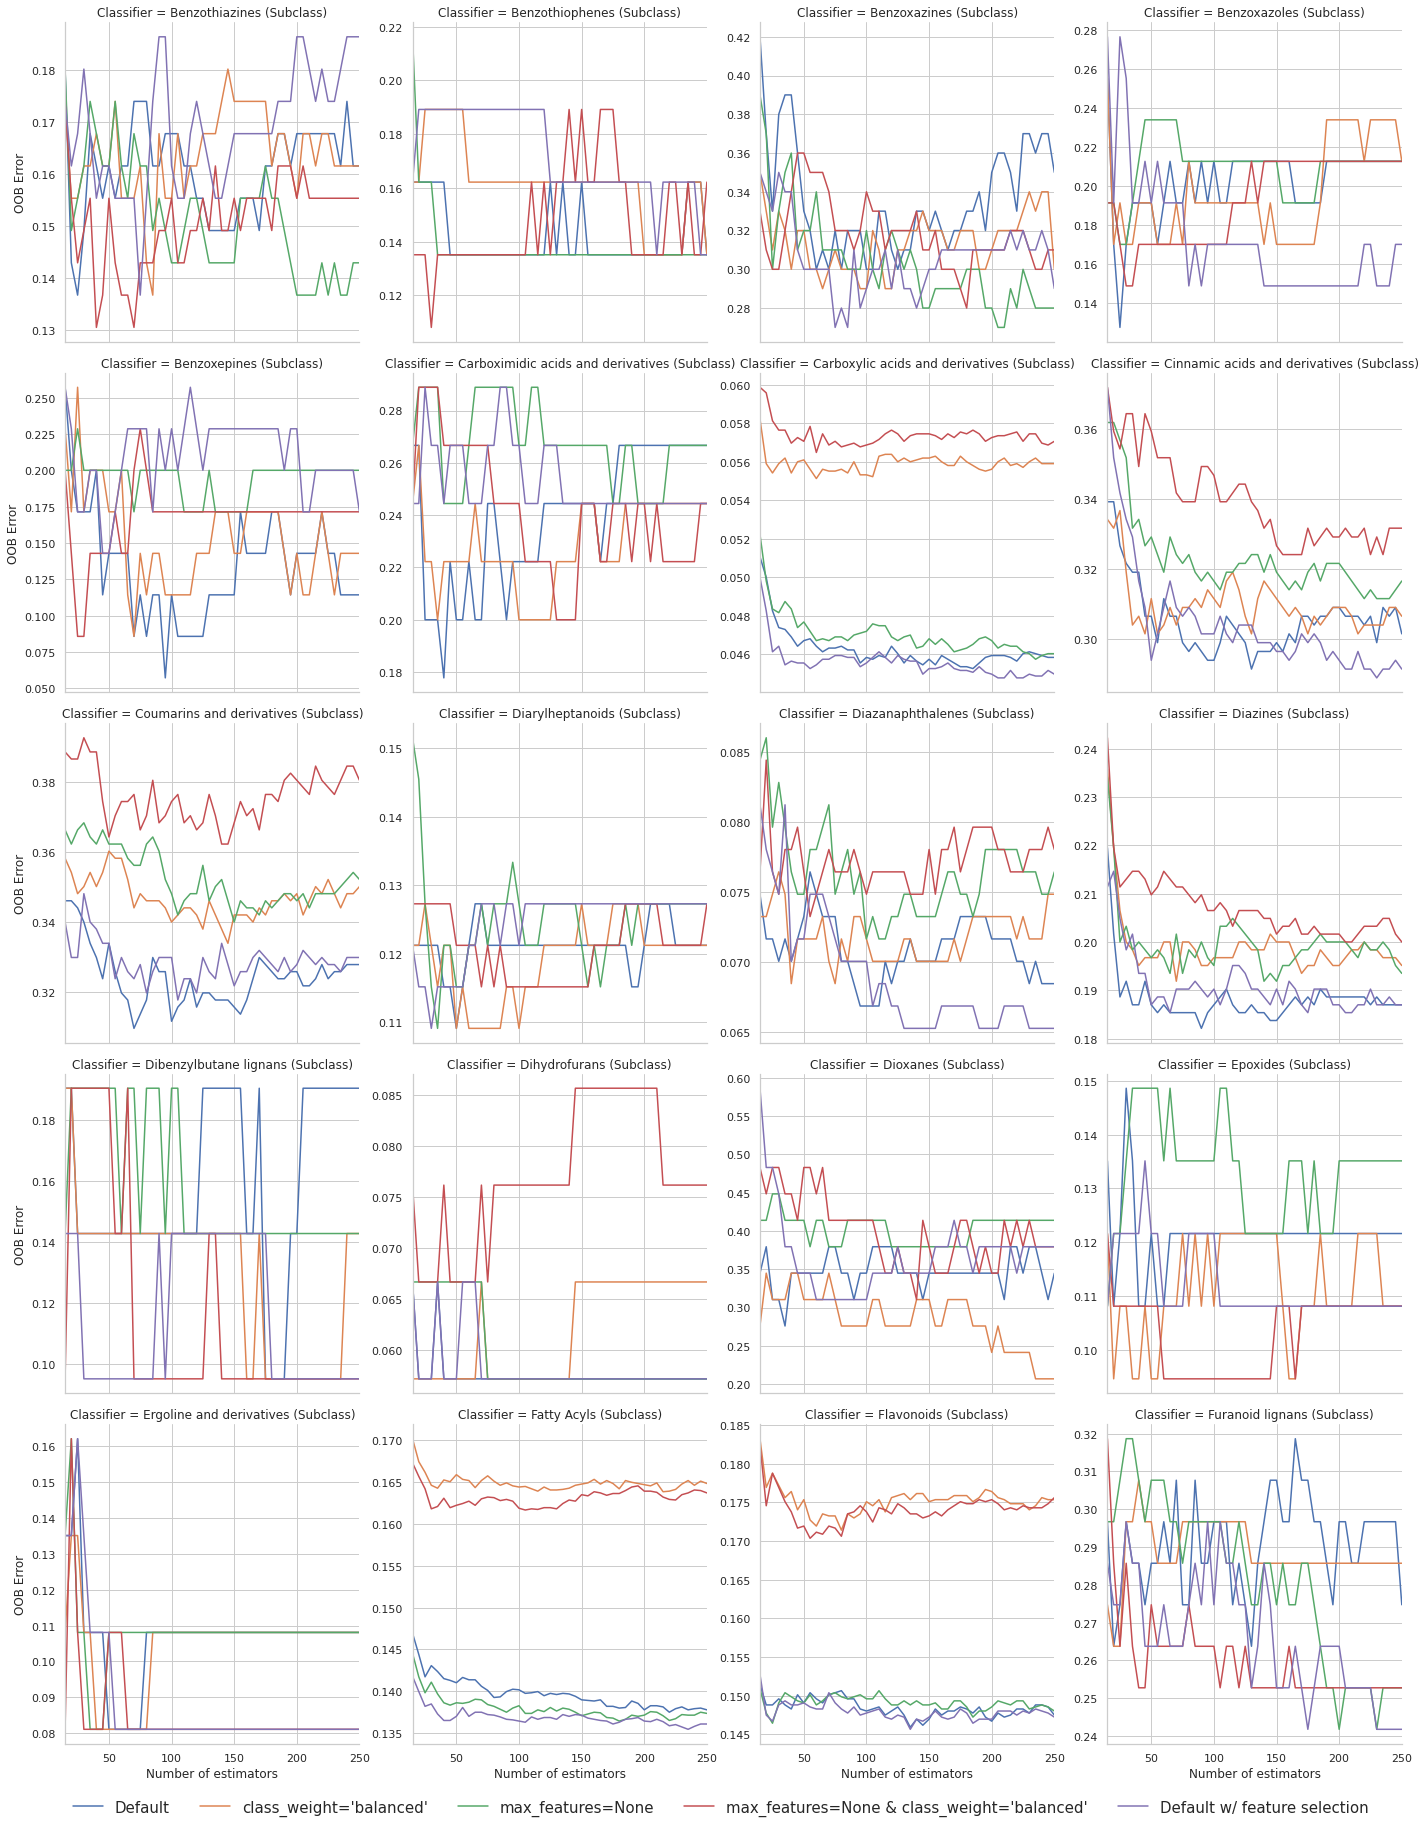

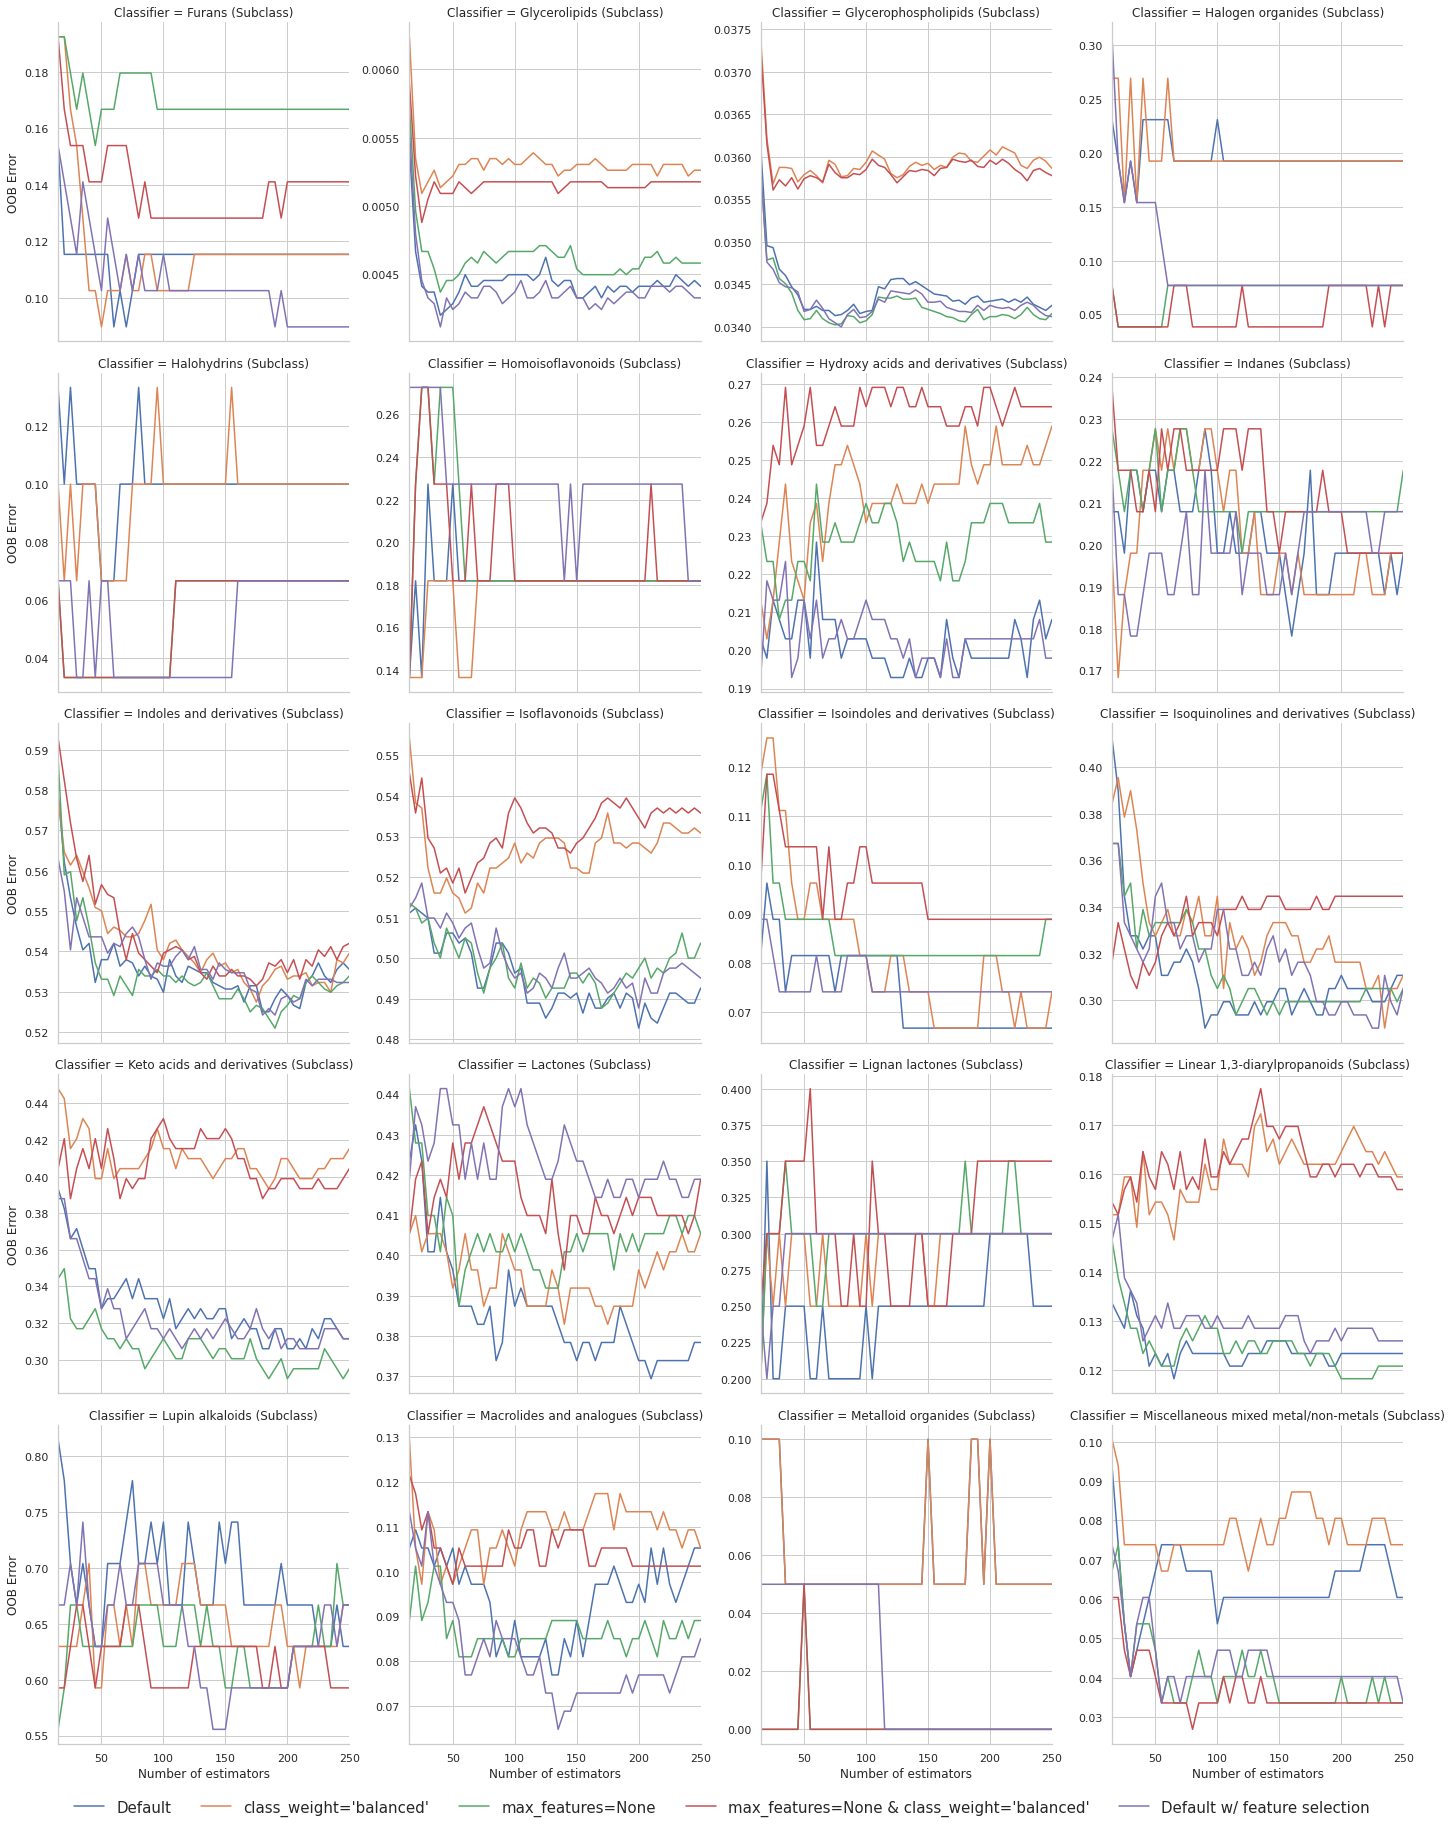

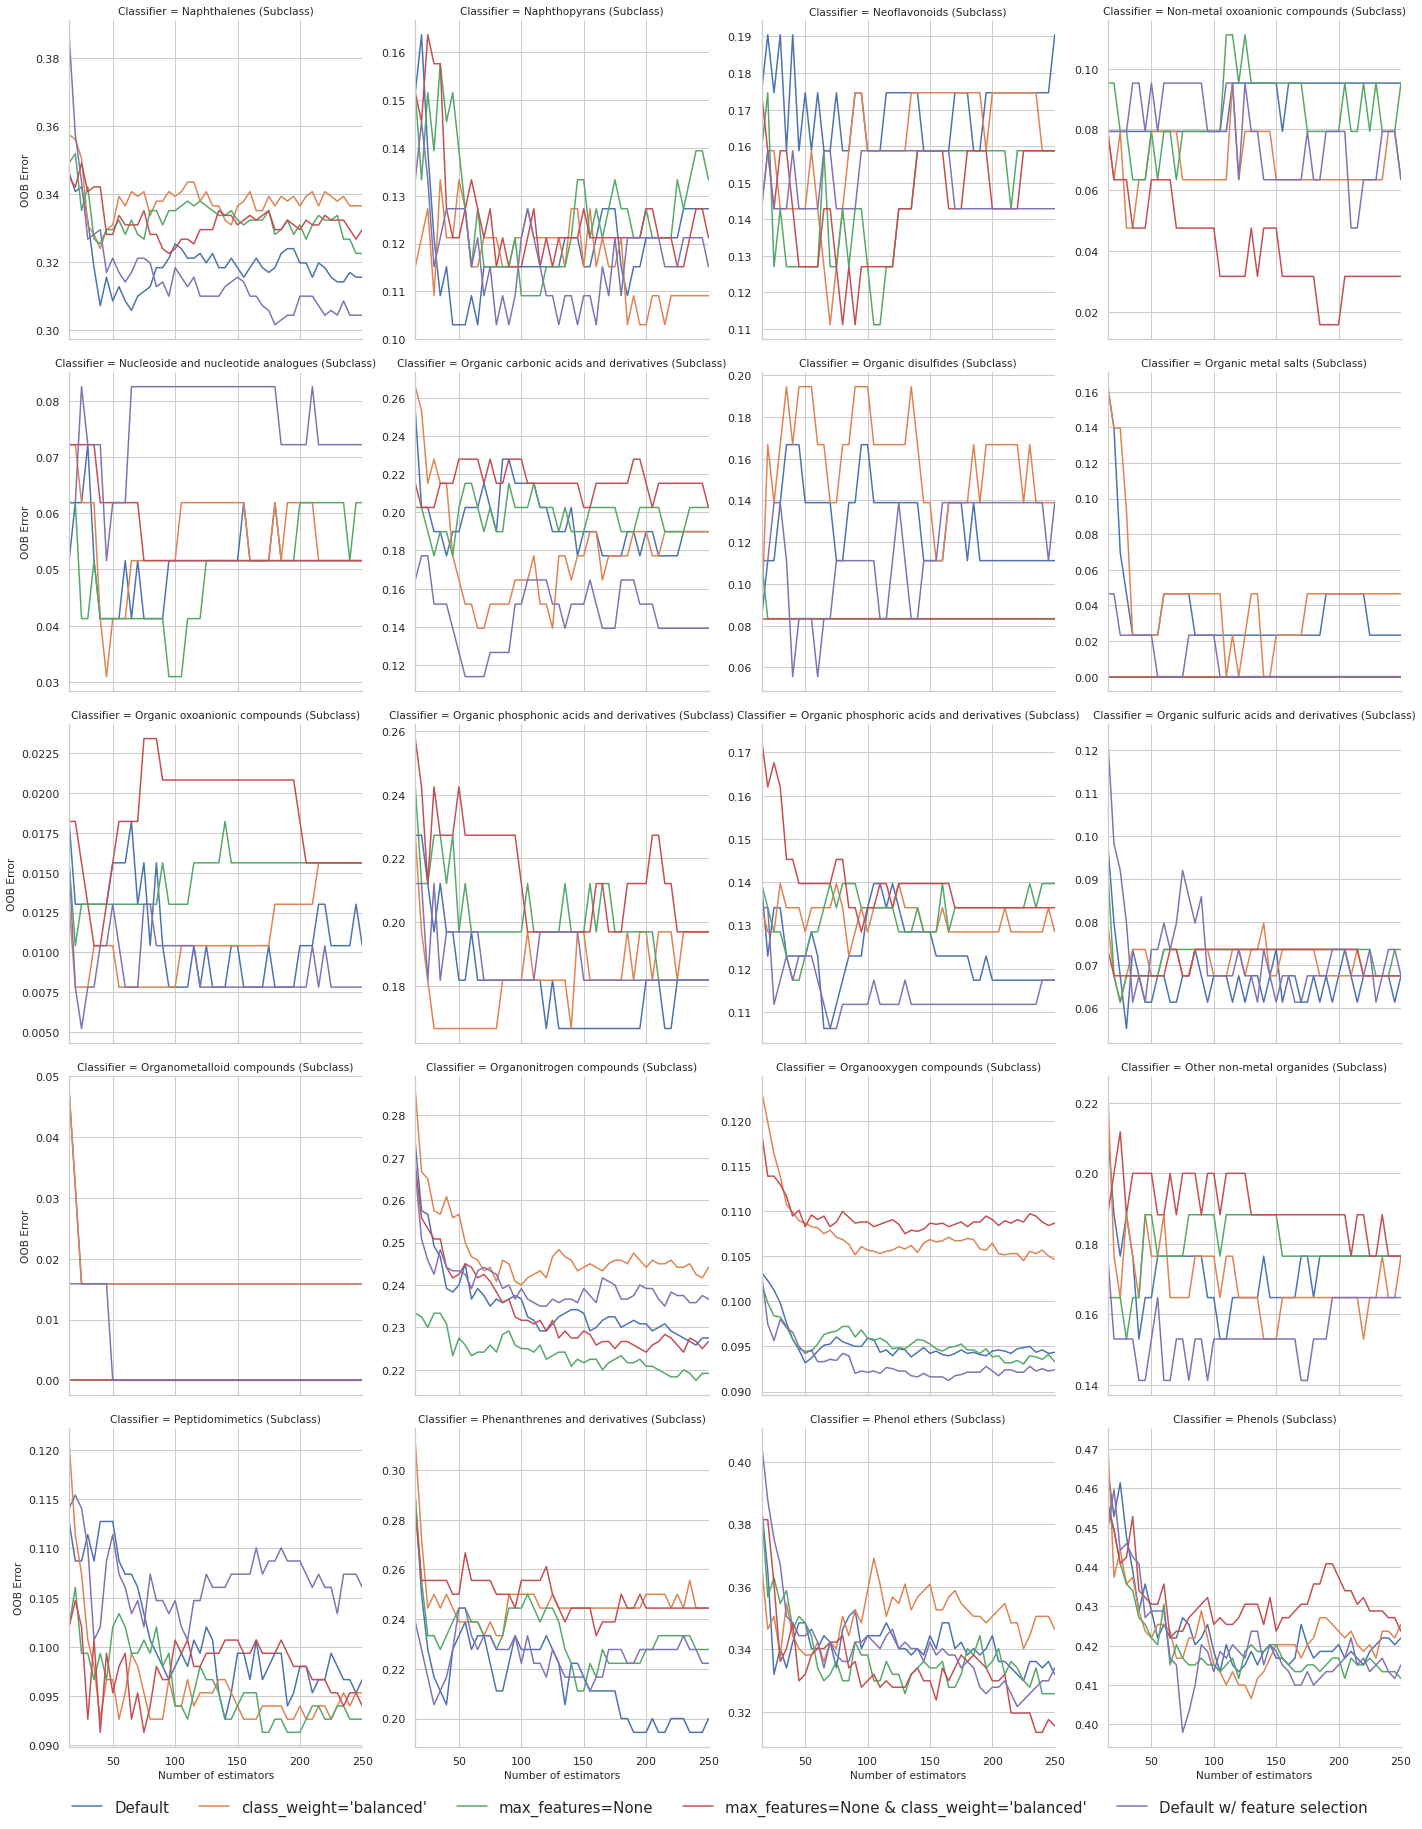

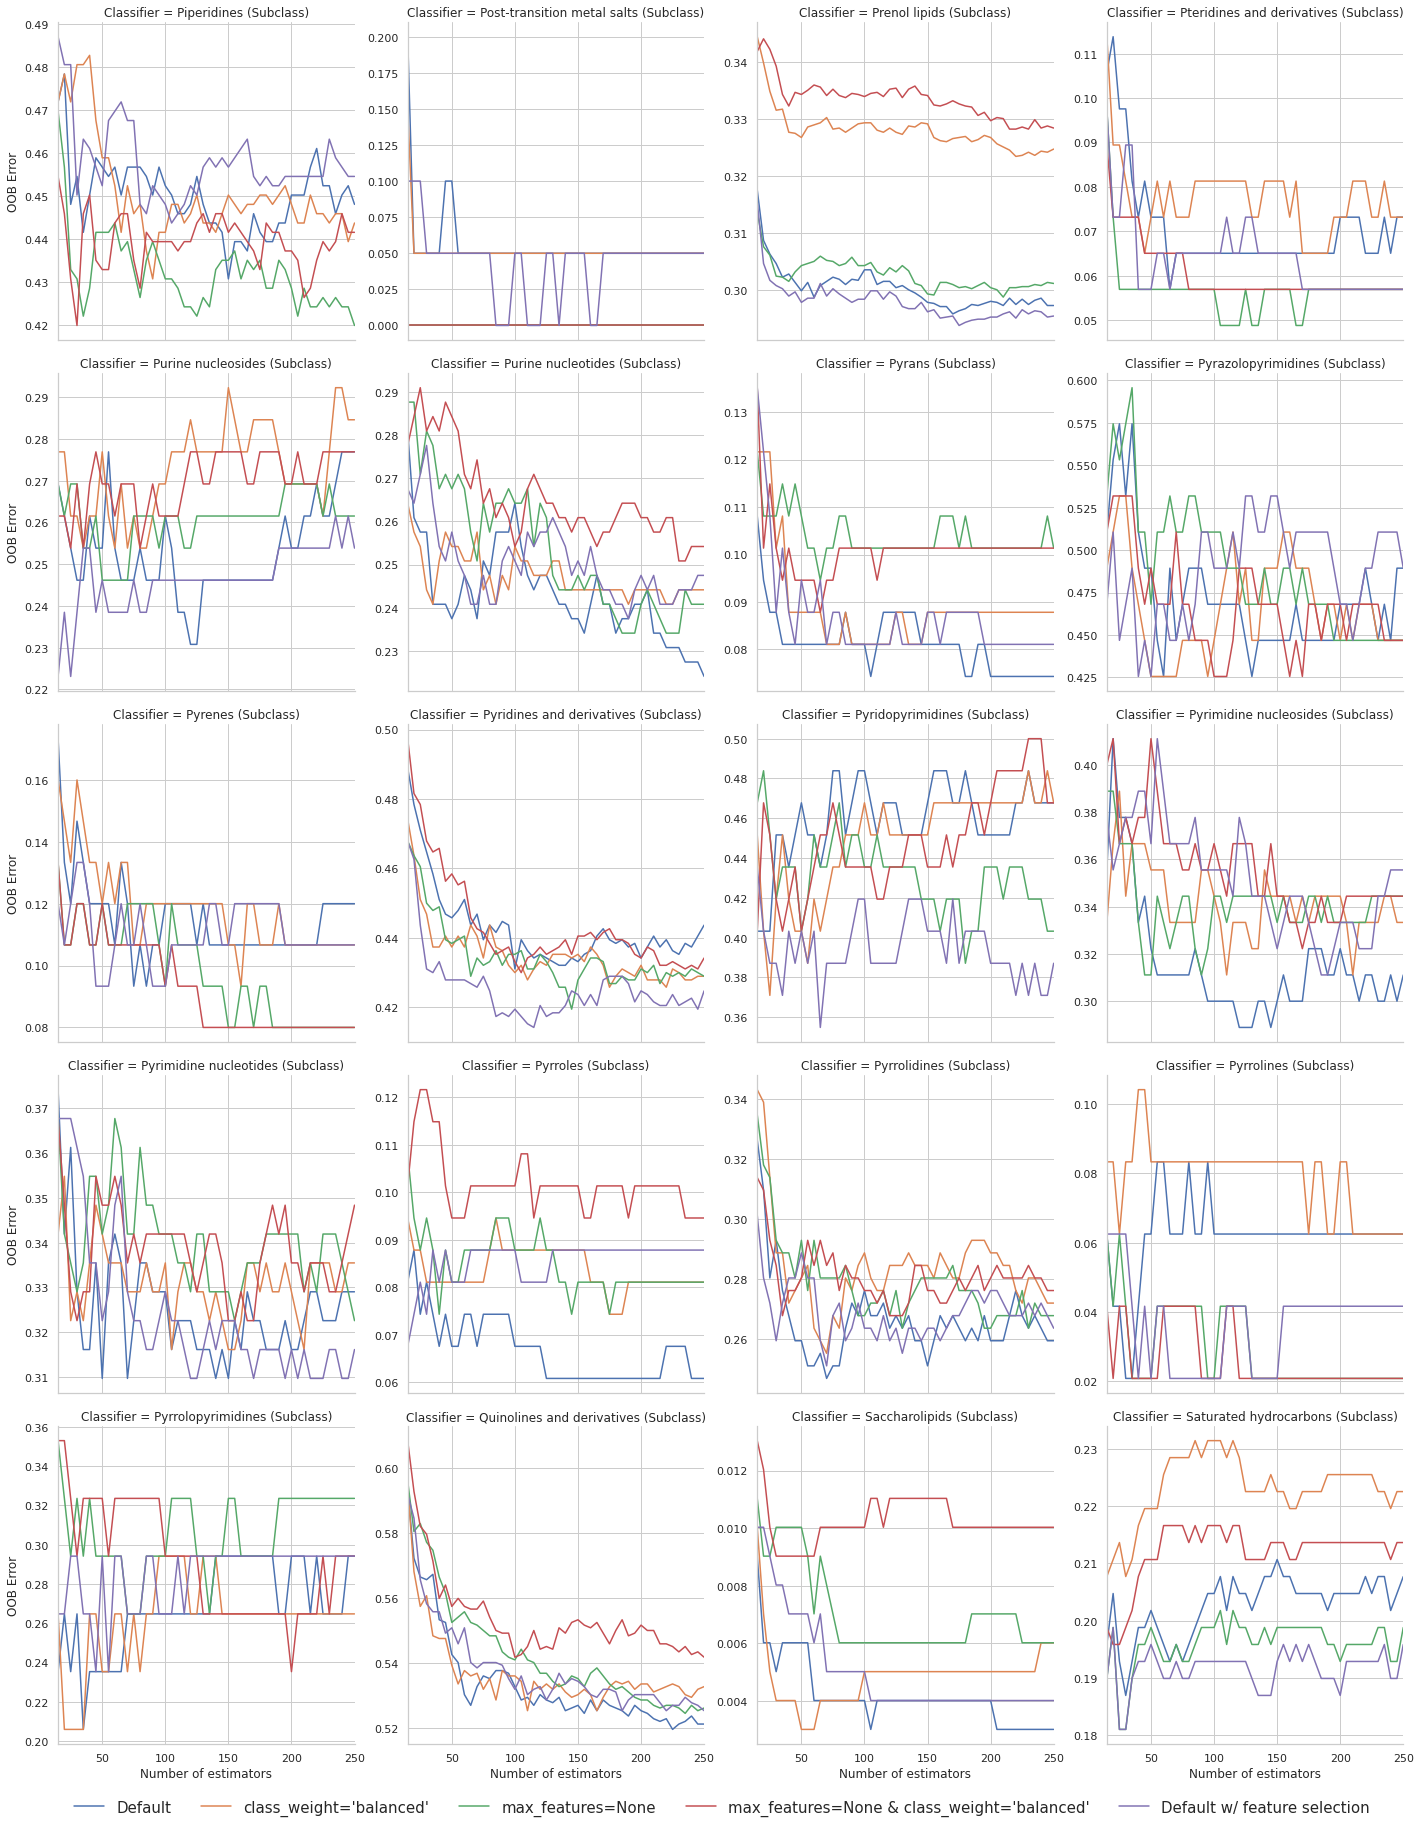

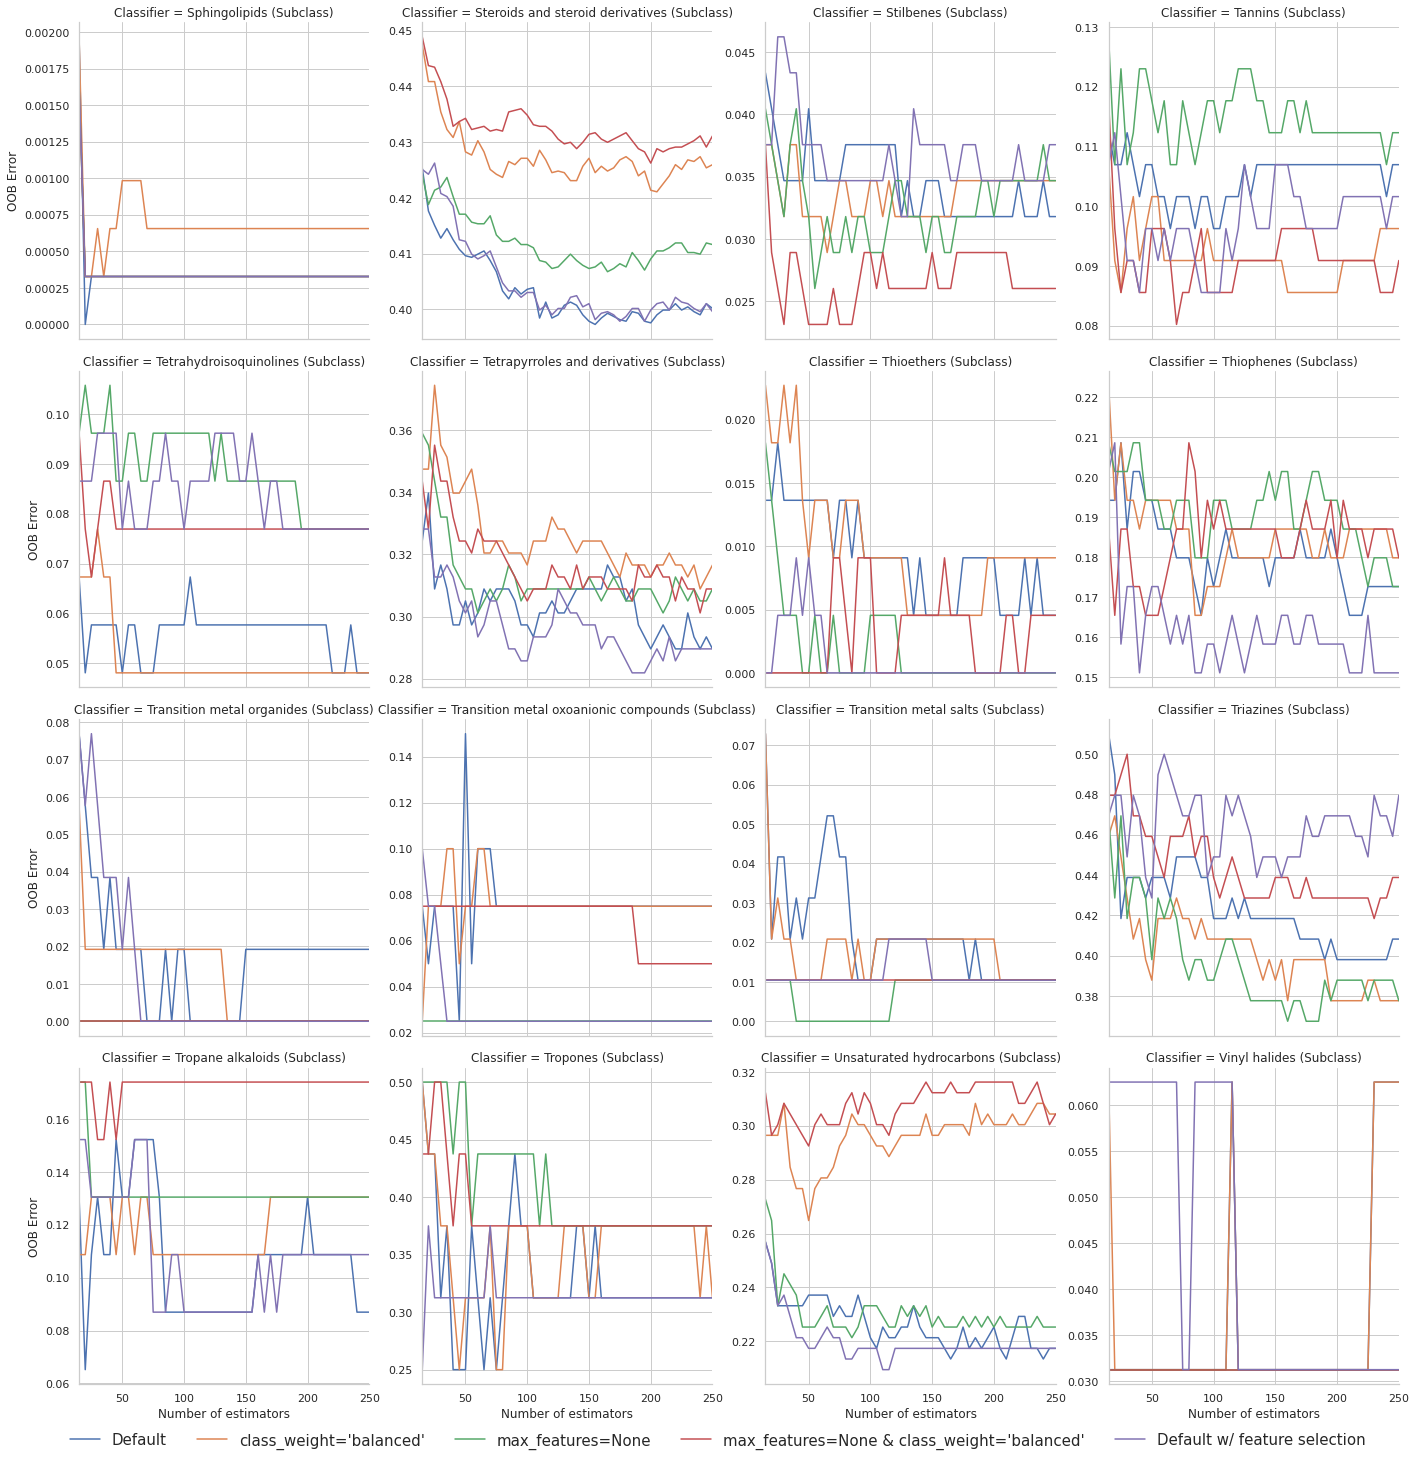

In [15]:
for i, part in enumerate(np.split(np.unique(df_subC['Classifier']), [20, 40, 60, 80, 100])):
    sns.set_theme(style='whitegrid')
    if i == 3:
        sns.set_theme(style='whitegrid', rc={'axes.labelsize': 10.5})
    g = sns.relplot(data=df_subC[df_subC['Classifier'].isin(part)], x='Number of estimators', y='OOB Error', hue='Label', col='Classifier', kind='line', 
                    facet_kws=dict(sharey=False), col_wrap=4, height=5)
    #Set automatic y limits
    for j, col in enumerate(g.axes):
        g.axes[j].set(ylim=None)
    g.set(xlim=(15, 250))
    sns.move_legend(g, "lower center", bbox_to_anchor=(0.425, -0.02), title=None, ncol=5, fontsize=15)

    plt.savefig(f'Plots/OOB_Score_Subclass_{i}.svg', bbox_inches='tight', transparent=True, dpi=500)
    plt.show()